2025-09-04 15:51:51.468826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757001111.775851      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757001111.862073      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
Num GPUs Available:  2

Class names: ['NORMAL', 'PNEUMONIA']

Training data distribution:
{'NORMAL': 1341, 'PNEUMONIA': 3875}

Displaying sample images...


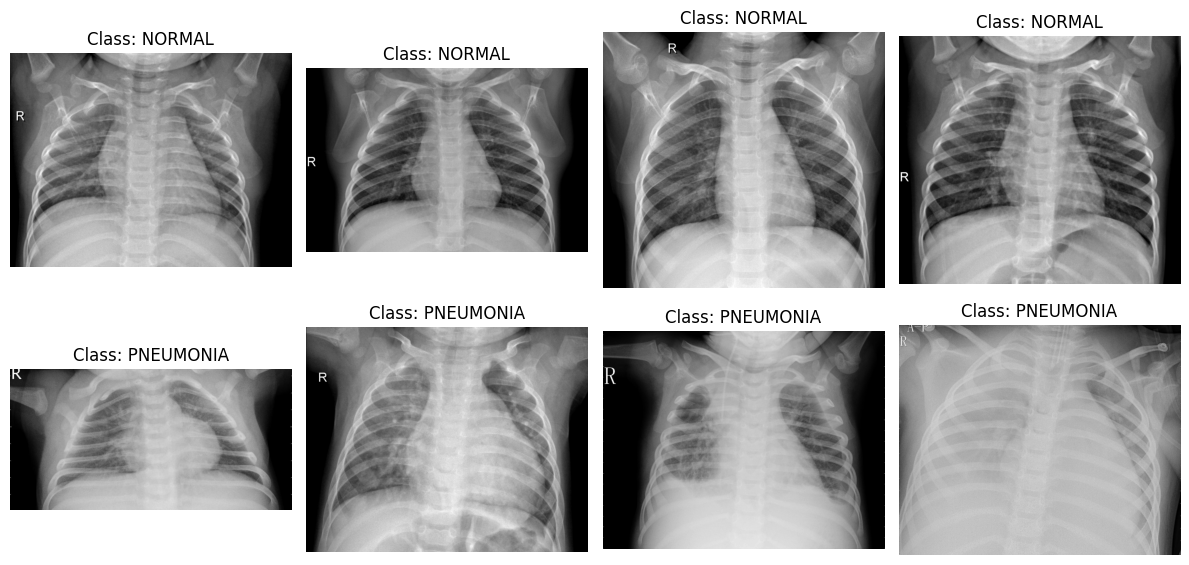

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# --- 1. Confirm GPU is Active ---
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


# --- 2. Define Paths and Explore Data ---
# The main directory is 'chest_xray', which contains 'train', 'test', 'val'
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(data_dir, 'train')

# Get the class names ('PNEUMONIA', 'NORMAL')
class_names = sorted(os.listdir(train_dir))
print(f"\nClass names: {class_names}")

# Count the number of images in each class
# Note: This dataset is imbalanced, which is a common real-world problem.
class_distribution = {c: len(os.listdir(os.path.join(train_dir, c))) for c in class_names}
print("\nTraining data distribution:")
print(class_distribution)


# --- 3. Display Sample Images from Each Class ---
print("\nDisplaying sample images...")
plt.figure(figsize=(12, 6))

for i, class_name in enumerate(class_names):
    # We'll show 4 samples for each class
    image_files = os.listdir(os.path.join(train_dir, class_name))
    sample_images = np.random.choice(image_files, 4)
    
    for j, image_name in enumerate(sample_images):
        image_path = os.path.join(train_dir, class_name, image_name)
        img = Image.open(image_path).convert('L') # Convert to grayscale
        
        plt.subplot(2, 4, i * 4 + j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class: {class_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# --- 1. Define Constants and Prepare Data Pipeline ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# The train_dir path was defined in the previous cell
# train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'

# Create the training dataset from the image folders
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',  # Binary classification (Normal vs Pneumonia)
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Create the validation dataset from the same image folders
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

# A layer for subtle data augmentation
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Prefetch data for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


# --- 2. Build the Model using Transfer Learning ---
# Load the MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the pre-trained layers
base_model.trainable = False

# Create our new custom model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
# Final classification layer with 1 unit and sigmoid activation for binary classification
outputs = layers.Dense(1, activation='sigmoid')(x) 
model = keras.Model(inputs, outputs)


# --- 3. Compile the Model ---
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print a summary of our model's architecture
print("\nModel built and compiled successfully.")
model.summary()

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


I0000 00:00:1757001134.334388      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757001134.335025      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model built and compiled successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5


I0000 00:00:1757001147.768874      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 171ms/step - accuracy: 0.7287 - loss: 0.5294 - val_accuracy: 0.9128 - val_loss: 0.2119
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9192 - loss: 0.2080 - val_accuracy: 0.9300 - val_loss: 0.1857
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9345 - loss: 0.1724 - val_accuracy: 0.9453 - val_loss: 0.1509
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9455 - loss: 0.1496 - val_accuracy: 0.9559 - val_loss: 0.1319
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9531 - loss: 0.1278 - val_accuracy: 0.9607 - val_loss: 0.1266


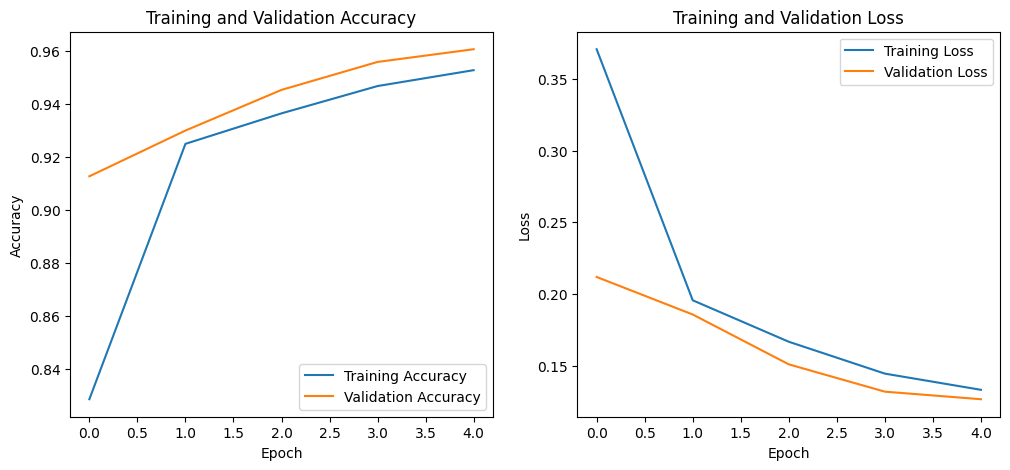


Module complete. Model saved successfully as 'pneumonia_model.keras'


In [3]:
# --- 1. Train the Model ---
# For this task, even 5 epochs with transfer learning can achieve high accuracy.
epochs = 5
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset
)

# --- 2. Visualize Training Results ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


# --- 3. Save the Final Model ---
filename = 'pneumonia_model.keras'
model.save(filename)
print(f"\nModule complete. Model saved successfully as '{filename}'")

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9552 - loss: 0.1254 - val_accuracy: 0.9588 - val_loss: 0.1242
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9579 - loss: 0.1222 - val_accuracy: 0.9607 - val_loss: 0.1185
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.9499 - loss: 0.1245 - val_accuracy: 0.9501 - val_loss: 0.1315
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9582 - loss: 0.1136 - val_accuracy: 0.9616 - val_loss: 0.1133
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9586 - loss: 0.1142 - val_accuracy: 0.9626 - val_loss: 0.1091


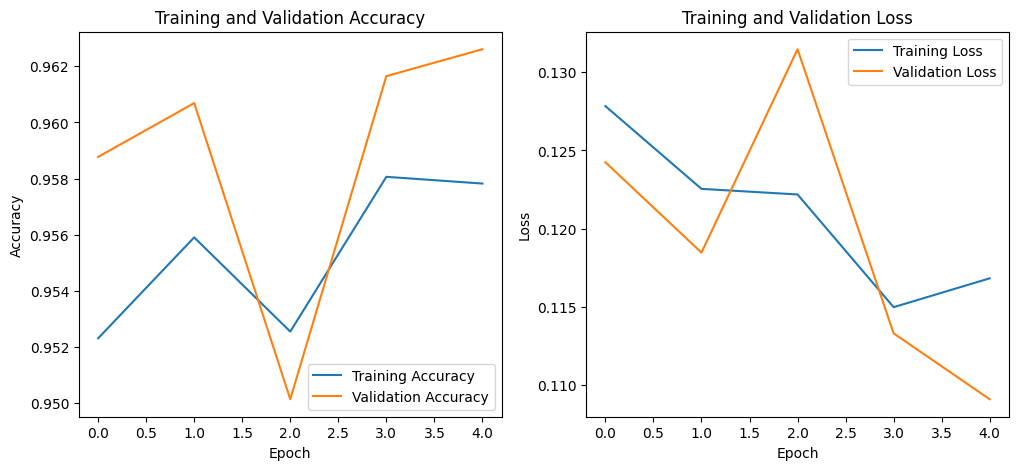


Module complete. Model saved successfully as 'pneumonia_model.keras'


In [4]:
# --- 1. Train the Model ---
# For this task, even 5 epochs with transfer learning can achieve high accuracy.
epochs = 5
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset
)

# --- 2. Visualize Training Results ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


# --- 3. Save the Final Model ---
filename = 'pneumonia_model.keras'
model.save(filename)
print(f"\nModule complete. Model saved successfully as '{filename}'")